## BRIEF OVERVIEW 

there are two pipelines : 
1) Jia En Low :  ordinal encoder + label encoder -> MICE imputer -> standard scaler -> multitaskelasticnet feature selection -> GBT Model / Logistic Model 

2) Kar Yan Ng :   label encoder -> simple imputer(mean) -> standard scaler -> PLS dimensionality reduction -> GBT Model / Logistic Model 

Analysis has been carried out by both of us at the end of the code 
  

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go

from sklearn.svm import SVC 
from sklearn.metrics import plot_roc_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from statistics import mean 
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskElasticNetCV,  MultiTaskLassoCV

from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_validate, KFold
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
import shap

In [2]:
train_df = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')
train_df_labels = pd.merge(train_df, labels, how= 'inner' ,on = 'respondent_id')
test_df = pd.read_csv('data/test_set_features.csv')
frames = [train_df, test_df]
df_merged = pd.concat(frames)

### EXPLORING DATASET

In [3]:
train_df_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [4]:
missingdata = train_df_labels.iloc[:, 1:39].notnull()
for column in missingdata.columns.values.tolist():
    print(column)
    print (missingdata[column].value_counts())
    print("") 

h1n1_concern
True     26615
False       92
Name: h1n1_concern, dtype: int64

h1n1_knowledge
True     26591
False      116
Name: h1n1_knowledge, dtype: int64

behavioral_antiviral_meds
True     26636
False       71
Name: behavioral_antiviral_meds, dtype: int64

behavioral_avoidance
True     26499
False      208
Name: behavioral_avoidance, dtype: int64

behavioral_face_mask
True     26688
False       19
Name: behavioral_face_mask, dtype: int64

behavioral_wash_hands
True     26665
False       42
Name: behavioral_wash_hands, dtype: int64

behavioral_large_gatherings
True     26620
False       87
Name: behavioral_large_gatherings, dtype: int64

behavioral_outside_home
True     26625
False       82
Name: behavioral_outside_home, dtype: int64

behavioral_touch_face
True     26579
False      128
Name: behavioral_touch_face, dtype: int64

doctor_recc_h1n1
True     24547
False     2160
Name: doctor_recc_h1n1, dtype: int64

doctor_recc_seasonal
True     24547
False     2160
Name: doctor_recc_sea

### PREPROCESSING 

drop missing values

In [5]:
train_df_labels.dropna(thresh=16, inplace = True)

combination of label and ordinal encoding

In [6]:
## ORDINAL ENCODING 

def ordinal_encoder(data,feature,feature_rank):
    
    ordinal_dict = {}
    
    for i, feature_value in enumerate(feature_rank):
        ordinal_dict[feature_value]=i+1
    
    data[feature] = data[feature].map(lambda x: ordinal_dict[x])
    
    return data

# replace with mode for income_poverty column
from collections import Counter
Counter(train_df_labels["income_poverty"])
train_df_labels['income_poverty'].fillna('<= $75,000, Above Poverty', inplace=True)

# then ordinal encode ( since OE cannot take NA values)
ordinal_encoder(train_df_labels, 'age_group', ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'])
ordinal_encoder(train_df_labels, 'income_poverty', ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'])


# LABEL ENCODING  
le = LabelEncoder()
cols_to_encode = ['employment_industry', 'employment_occupation', 'education', 'health_insurance', 'doctor_recc_h1n1', 'doctor_recc_seasonal']

# apply label encoding to selected columns
for col in cols_to_encode:
    train_df_labels[col] = le.fit_transform(train_df_labels[col])


train_df_labels_withNA = train_df_labels.apply(lambda series: pd.Series(
    le.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

dealing with missing data

In [7]:
train_df_labels_withNA = train_df_labels_withNA.astype(pd.Int64Dtype() )

# calling the  MICE class
mice_imputer = IterativeImputer()
# imputing the missing value with mice imputer
mice_imputed_df = mice_imputer.fit_transform(train_df_labels_withNA)

mice_imputed_df = mice_imputed_df.round(0)

mice_imputed_df = pd.DataFrame(mice_imputed_df, columns=train_df_labels_withNA.columns)
mice_imputed_df = mice_imputed_df.astype(pd.Int64Dtype() )

corr matrix 

<AxesSubplot:title={'center':'Flu dataset correlation'}>

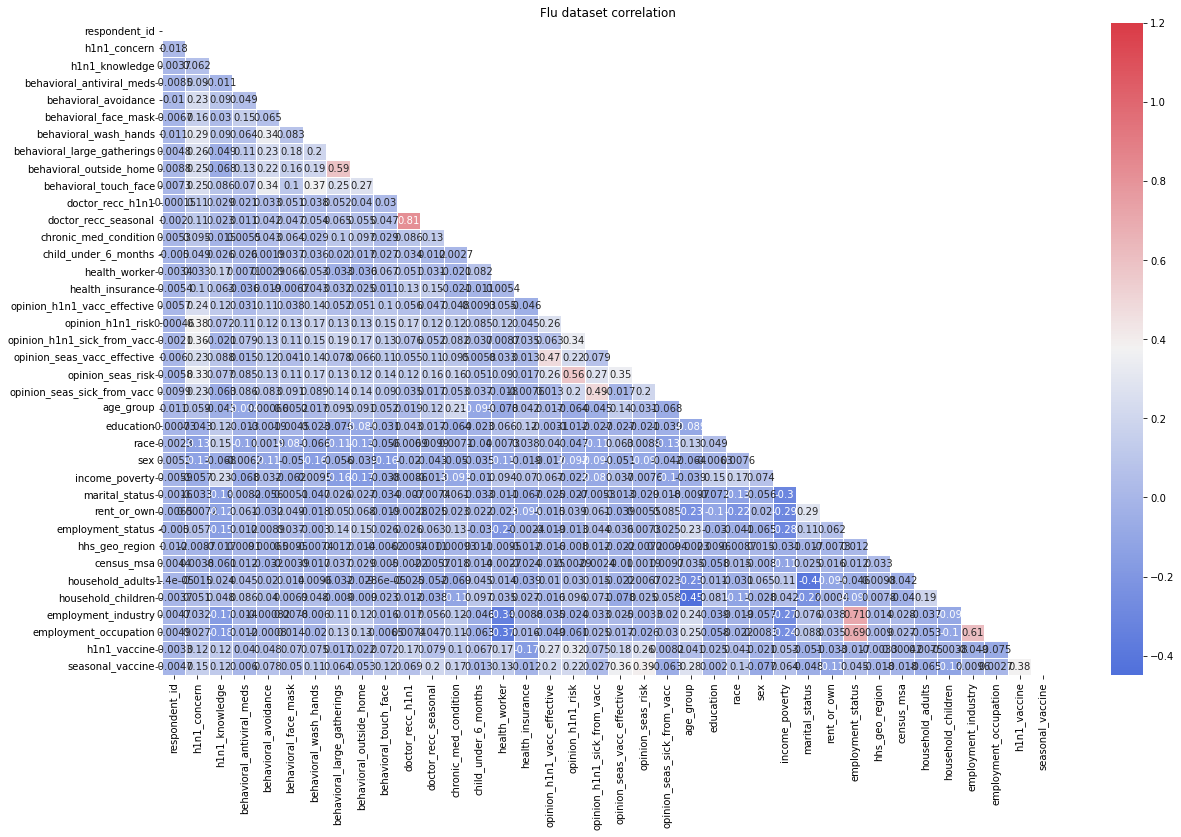

In [13]:
corrMatt = mice_imputed_df.corr()
#generate a mask for the upper triangle
mask = np.zeros_like(corrMatt) # returns the matrix with each value as 0
mask[np.triu_indices_from(mask)] = True # value 1 in upper triangle of the matrix 

#set up matplot fig 
fig, ax = plt.subplots(figsize = (20,12))
plt.title('Flu dataset correlation')

#generate a custom diverging colormap 
cmap= sns.diverging_palette(260,10,as_cmap = True) 

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt,vmax = 1.2, square = False, cmap = cmap , mask = mask, ax= ax, annot = True, fmt = '.2g', linewidths = 1 )

Split dataset to features and outcome 

In [8]:
h1n1 = mice_imputed_df.h1n1_vaccine.astype('int')
seas = mice_imputed_df.seasonal_vaccine.astype('int')
x = mice_imputed_df.drop(columns= ['h1n1_vaccine', 'seasonal_vaccine'], axis= 1)

# target multilabel output 
y = pd.concat([seas, h1n1], axis =1)

Data Normalisation

In [9]:
scaler = StandardScaler()
scaler.fit_transform(x)
scaled_x = pd.DataFrame(x)

## PIPELINE BY JIA EN LOW


### LOGISTIC REGRESSION + MULTITASKELASTICNET

before feature selection

In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

clf_lr_bfs = MultiOutputClassifier(LogisticRegression())
clf_lr_bfs.fit(scaled_x, y)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_predict to obtain probability predictions
y_pred_proba = cross_val_predict(clf_lr_bfs, scaled_x, y, cv=cv, method='predict_proba')

# Separate the probabilities for each target variable
y_pred_proba_target1 = np.array([prob[1] for prob in y_pred_proba[0]])
y_pred_proba_target2 = np.array([prob[1] for prob in y_pred_proba[1]])

# # Calculate the ROC AUC scores for each target variable
roc_auc_target1 = roc_auc_score(y.iloc[:, 0], y_pred_proba_target1)
roc_auc_target2 = roc_auc_score(y.iloc[:, 1], y_pred_proba_target2)

# # Print the ROC AUC scores
print("ROC AUC score for Seasonal Flu vaccine:", roc_auc_target1)
print("ROC AUC score for H1N1 Vaccine:", roc_auc_target2)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

ROC AUC score for Seasonal Flu vaccine: 0.7951169399261812
ROC AUC score for H1N1 Vaccine: 0.7646373748984446


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


after feature selection 

In [15]:
# nested K-fold 
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score

# Define the pipeline with the model and feature selection
pipeline = Pipeline([ 
    ('fs', SelectFromModel(MultiTaskElasticNet())), 
    ('clf',  MultiOutputClassifier(LogisticRegression(), n_jobs = -1))
])

# Define the parameter grid for hyperparameter tuning
grid_params = {
    'fs__estimator__alpha': [0.01, 0.1, 1.0, 10],
    'fs__estimator__l1_ratio': [0.1, 0.3, 0.5, 1.0]
}

# Define the outer cross-validation strategy
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store the cross-validation results
roc_auc_scores_target1 = []
roc_auc_scores_target2 = []

# Outer loop for nested cross-validation
for train_outer, test_outer in outer_cv.split(scaled_x, y):
    # Split the data into training and test sets for the outer fold
    x_train_outer, x_test_outer = scaled_x.loc[train_outer,:], scaled_x.loc[test_outer,:]
    
    y_train_outer, y_test_outer = y.iloc[train_outer], y.iloc[test_outer]
    
    # Define the inner cross-validation strategy
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform grid search with cross-validation on the training set of the outer fold
    clf = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='roc_auc', return_train_score=True)
    clf.fit(x_train_outer, y_train_outer)
    logistic_best = clf.best_estimator_
    
    # Use cross_val_predict to obtain probability predictions on the test set of the outer fold
    y_pred_proba = cross_val_predict(logistic_best, x_test_outer, y_test_outer, cv=inner_cv, method='predict_proba')
    
    # Separate the probabilities for each target variable
    y_pred_proba_target1 = np.array([prob[1] for prob in y_pred_proba[0]])
    y_pred_proba_target2 = np.array([prob[1] for prob in y_pred_proba[1]])
    
    # Calculate the ROC AUC scores for each target variable and store them
    roc_auc_scores_target1.append(roc_auc_score(y_test_outer.iloc[:, 0], y_pred_proba_target1))
    roc_auc_scores_target2.append(roc_auc_score(y_test_outer.iloc[:, 1], y_pred_proba_target2))

# Print the mean ROC AUC scores for each target variable across all outer folds
print("Mean ROC AUC score for Seasonal Flu vaccine:", np.mean(roc_auc_scores_target1))
print("Mean ROC AUC score for H1N1 Vaccine:", np.mean(roc_auc_scores_target2))


Mean ROC AUC score for Seasonal Flu vaccine: 0.8335960407184537
Mean ROC AUC score for H1N1 Vaccine: 0.8223952632773057


In [40]:
train_outer

array([    0,     1,     2, ..., 26702, 26704, 26706])

## PIPELINE BY KAR YAN NG

In [43]:
scaled_x

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1,0,0,0,0,0,0,1,1,...,0,1,0,1,8,2,0,0,21,23
1,1,3,2,0,1,0,1,0,1,1,...,0,1,1,0,1,0,0,0,12,19
2,2,1,1,0,1,0,0,0,0,0,...,1,1,0,0,9,0,2,0,14,21
3,3,1,1,0,1,0,1,1,0,0,...,0,1,1,1,5,1,0,0,21,23
4,4,2,1,0,1,0,1,1,0,1,...,1,0,0,0,9,0,1,0,18,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2,0,0,1,0,0,0,1,0,...,1,1,0,1,9,2,0,0,21,23
26703,26703,1,2,0,1,0,1,0,0,0,...,1,1,1,0,6,1,1,0,4,2
26704,26704,2,2,0,1,1,1,1,0,1,...,1,1,0,1,6,0,0,0,21,23
26705,26705,1,1,0,0,0,0,0,0,0,...,1,0,1,0,5,2,1,0,4,6


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cross_decomposition import PLSRegression, CCA

# Load data
features_dataset = pd.read_csv('data/training_set_features.csv') 
target_dataset = pd.read_csv('data/training_set_labels.csv')  
# Preprocess the features dataset

categorical_columns = features_dataset.select_dtypes(include=['object']).columns
numerical_columns = features_dataset.select_dtypes(include=['float64', 'int64']).columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Apply preprocessing
# features_dataset = preprocessor.fit_transform(features_dataset)

# Standardize the features
# scaler = StandardScaler()
# scaled_x = scaler.fit_transform(features_dataset)

# Create the target variable dataset
# y = target_dataset[['h1n1_vaccine', 'seasonal_vaccine']] 

# Define the pipelines with the models, one for PLS and another for CCA, now with Logistic Regression
pls_pipeline = Pipeline([
    ('fs', SelectFromModel(PLSRegression(n_components=2))),
    ('clf', MultiOutputClassifier(LogisticRegression(), n_jobs=-1))
])

# cca_pipeline = Pipeline([
#     ('fs', SelectFromModel(CCA(n_components=2))),
#     ('clf', MultiOutputClassifier(LogisticRegression(), n_jobs=-1))
# ])

# Function to perform nested cross-validation and return mean ROC AUC scores
def nested_cv(pipeline):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores_target1 = []
    roc_auc_scores_target2 = []
    for train_outer, test_outer in outer_cv.split(scaled_x, y):
        
        x_train_outer, x_test_outer = scaled_x[train_outer], scaled_x[test_outer]
        y_train_outer, y_test_outer = y[train_outer], y[test_outer]
        print(type(x_train_outer))
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        pipeline.fit(x_train_outer, y_train_outer)
        y_pred_proba = cross_val_predict(pipeline, x_test_outer, y_test_outer, cv=inner_cv, method='predict_proba')
        y_pred_proba_target1 = y_pred_proba[0][:, 1]
        y_pred_proba_target2 = y_pred_proba[1][:, 1]
        roc_auc_scores_target1.append(roc_auc_score(y_test_outer.iloc[:, 0], y_pred_proba_target1))
        roc_auc_scores_target2.append(roc_auc_score(y_test_outer.iloc[:, 1], y_pred_proba_target2))
    return np.mean(roc_auc_scores_target1), np.mean(roc_auc_scores_target2)

# Perform nested cross-validation for the PLS pipeline
pls_roc_auc_scores = nested_cv(pls_pipeline)

# Perform nested cross-validation for the CCA pipeline
cca_roc_auc_scores = nested_cv(cca_pipeline)

# Print the mean ROC AUC scores for each pipeline
print("PLS Pipeline")
print("Mean ROC AUC score for H1N1 Vaccine:", pls_roc_auc_scores[0])
print("Mean ROC AUC score for Seasonal Flu Vaccine:", pls_roc_auc_scores[1])
print("\nCCA Pipeline")
print("Mean ROC AUC score for H1N1 Vaccine:", cca_roc_auc_scores[0])
print("Mean ROC AUC score for Seasonal Flu Vaccine:", cca_roc_auc_scores[1])


KeyError: "None of [Int64Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,\n               10,\n            ...\n            26697, 26698, 26699, 26700, 26701, 26702, 26703, 26704, 26705,\n            26706],\n           dtype='int64', length=21365)] are in the [columns]"

pandas.core.frame.DataFrame

CCA DIMENSIONALITY REDUCTION  + ONEHOTENCODER + LOGISTIC REGRESSION 

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Define hyperparameters for the grid search
hyperparameters = {
    'fs_estimator_n_components': [6,7,8],  # changing the number of components in PLSRegression and CCA
    'clf_estimator_C': [0.1, 1, 10, 100]  # changing the regularization strength in LogisticRegression
}

def nested_cv(pipeline, grid_params):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    roc_auc_scores_target1 = []
    roc_auc_scores_target2 = []

    for train_outer, test_outer in outer_cv.split(scaled_x, y):
        x_train_outer, x_test_outer = scaled_x[train_outer], scaled_x[test_outer]
        y_train_outer, y_test_outer = y.iloc[train_outer], y.iloc[test_outer]

        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        clf = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='roc_auc', return_train_score=True)
        clf.fit(x_train_outer, y_train_outer)

        y_pred_proba = clf.predict_proba(x_test_outer)

        y_pred_proba_target1 = np.array([prob[1] for prob in y_pred_proba[0]])
        y_pred_proba_target2 = np.array([prob[1] for prob in y_pred_proba[1]])

        roc_auc_scores_target1.append(roc_auc_score(y_test_outer.iloc[:, 0], y_pred_proba_target1))
        roc_auc_scores_target2.append(roc_auc_score(y_test_outer.iloc[:, 1], y_pred_proba_target2))

    return np.mean(roc_auc_scores_target1), np.mean(roc_auc_scores_target2)

pls_roc_auc_scores = nested_cv(pls_pipeline, hyperparameters)
cca_roc_auc_scores = nested_cv(cca_pipeline, hyperparameters)

pls_grid_search = GridSearchCV(pls_pipeline, param_grid=hyperparameters, cv=5, scoring='roc_auc')
pls_grid_search.fit(scaled_x, y)

cca_grid_search = GridSearchCV(cca_pipeline, param_grid=hyperparameters, cv=5, scoring='roc_auc')
cca_grid_search.fit(scaled_x, y)

best_params_pls = pls_grid_search.best_params_
best_params_cca = cca_grid_search.best_params_

print("PLS Pipeline - After tuning")
print("Best parameters for PLS pipeline:", best_params_pls)
print("Mean ROC AUC score for H1N1 Vaccine:", pls_roc_auc_scores[0])
print("Mean ROC AUC score for Seasonal Flu Vaccine:", pls_roc_auc_scores[1])

print("\nCCA Pipeline - After tuning")
print("Best parameters for CCA pipeline:", best_params_cca)
print("Mean ROC AUC score for H1N1 Vaccine:", cca_roc_auc_scores[0])
print("Mean ROC AUC score for Seasonal Flu Vaccine:", cca_roc_auc_scores[1])

NameError: name 'pls_pipeline' is not defined

before feature selection

## PIPELINE BY JIA EN LOW 

### GRADIENT BOOSTING CLASSIFIER 

before feature selection 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf_beforefs =  MultiOutputClassifier(GradientBoostingClassifier())
clf_beforefs.fit(scaled_x, y)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_predict to obtain probability predictions
y_pred_proba = cross_val_predict(clf_beforefs, scaled_x, y, cv=cv, method='predict_proba')

# Separate the probabilities for each target variable
y_pred_proba_target1 = np.array([prob[1] for prob in y_pred_proba[0]])
y_pred_proba_target2 = np.array([prob[1] for prob in y_pred_proba[1]])

# # Calculate the ROC AUC scores for each target variable
roc_auc_target1 = roc_auc_score(y.iloc[:, 0], y_pred_proba_target1)
roc_auc_target2 = roc_auc_score(y.iloc[:, 1], y_pred_proba_target2)

# # Print the ROC AUC scores
print("ROC AUC score for Seasonal Flu vaccine:", roc_auc_target1)
print("ROC AUC score for H1N1 Vaccine:", roc_auc_target2)


after feature selection 

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import roc_auc_score
import numpy as np

# Define the pipeline
pipeline = Pipeline([
    ('fs', SelectFromModel(MultiTaskElasticNet())),
    ('clf', MultiOutputClassifier(GradientBoostingClassifier(), n_jobs=-1))
])

# Define the hyperparameter grid
grid_params = {
    'fs__estimator__alpha': [0.01, 0.1, 1.0, 10],
    'fs__estimator__l1_ratio': [0.1, 0.3, 0.5, 1.0],
    'clf__estimator__learning_rate': [0.01, 0.05, 0.1],
    'clf__estimator__max_depth': [5, 8, 12],
    'clf__estimator__criterion': ['friedman_mse', 'squared_error']
}

# Define the nested k-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the GridSearchCV object with nested k-fold cross-validation
clf = GridSearchCV(
    pipeline,
    grid_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Perform the nested k-fold cross-validation
roc_auc_scores_target1 = []
roc_auc_scores_target2 = []
for train_outer_idx, test_outer_idx in cv.split(scaled_x, y):
    X_train_outer, X_test_outer = scaled_x.iloc[train_outer_idx], scaled_x.iloc[test_outer_idx]
    y_train_outer, y_test_outer = y.iloc[train_outer_idx], y.iloc[test_outer_idx]
    
    clf.fit(X_train_outer, y_train_outer)
    rf_best = clf.best_estimator_

        # Use cross_val_predict to obtain probability predictions on the test set of the outer fold
    y_pred_proba = cross_val_predict(rf_best, X_test_outer, y_test_outer, cv=cv, method='predict_proba')
    
    # Separate the probabilities for each target variable
    y_pred_proba_target1 = np.array([prob[1] for prob in y_pred_proba[0]])
    y_pred_proba_target2 = np.array([prob[1] for prob in y_pred_proba[1]])
    
    # Calculate the ROC AUC scores for each target variable and store them
    roc_auc_scores_target1.append(roc_auc_score(y_test_outer.iloc[:, 0], y_pred_proba_target1))
    roc_auc_scores_target2.append(roc_auc_score(y_test_outer.iloc[:, 1], y_pred_proba_target2))

# Print the mean ROC AUC scores for each target variable across all outer folds
print("Mean ROC AUC score for Seasonal Flu vaccine:", np.mean(roc_auc_scores_target1))
print("Mean ROC AUC score for H1N1 Vaccine:", np.mean(roc_auc_scores_target2))


## PIPELINE BY KAR YAN NG

CCA DIMENSIONALITY REDUCTION  + ONEHOTENCODER + LOGISTIC REGRESSION 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cross_decomposition import PLSRegression, CCA

# Load data
# features_dataset = pd.read_csv('training_set_features.csv')  # replace with your actual file
# target_dataset = pd.read_csv('training_set_labels.csv')  # replace with your actual file

# Preprocess the features dataset
# categorical_columns = features_dataset.select_dtypes(include=['object']).columns
# numerical_columns = features_dataset.select_dtypes(include=['float64', 'int64']).columns

# Create preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', SimpleImputer(strategy='mean'), numerical_columns),
#         ('cat', OneHotEncoder(), categorical_columns)
#     ])

# Apply preprocessing
# features_dataset = preprocessor.fit_transform(features_dataset)

# Standardize the features
# scaler = StandardScaler()
# scaled_x = scaler.fit_transform(features_dataset)

# Create the target variable dataset
# y = target_dataset[['h1n1_vaccine', 'seasonal_vaccine']]  

# Define the pipelines with the models, one for PLS and another for CCA, now with Gradient Boosting
pls_pipeline = Pipeline([
    ('fs', SelectFromModel(PLSRegression(n_components=2))),
    ('clf', MultiOutputClassifier(GradientBoostingClassifier(), n_jobs=-1))
])

# cca_pipeline = Pipeline([
#     ('fs', SelectFromModel(CCA(n_components=2))),
#     ('clf', MultiOutputClassifier(GradientBoostingClassifier(), n_jobs=-1))
# ])

# Define the parameter grids for GridSearchCV
pls_param_grid = {
    'fs__estimator__n_components': [1, 2, 3],
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__learning_rate': [0.1, 0.05, 0.01]
}

# cca_param_grid = {
#     'fs__estimator__n_components': [1, 2, 3],
#     'clf__estimator__n_estimators': [50, 100, 200],
#     'clf__estimator__learning_rate': [0.1, 0.05, 0.01]
# }

# Perform nested cross-validation with GridSearchCV for the PLS pipeline
pls_grid_search = GridSearchCV(pls_pipeline, param_grid=pls_param_grid, cv=5, scoring='roc_auc')
pls_grid_search.fit(scaled_x, y)
best_pls_params = pls_grid_search.best_params_
best_pls_roc_auc_scores = nested_cv(pls_grid_search.best_estimator_)

# Perform nested cross-validation with GridSearchCV for the CCA pipeline
# cca_grid_search = GridSearchCV(cca_pipeline, param_grid=cca_param_grid, cv=5, scoring='roc_auc')
# cca_grid_search.fit(scaled_x, y)
# best_cca_params = cca_grid_search.best_params_
# best_cca_roc_auc_scores = nested_cv(cca_grid_search.best_estimator_)

# Print the best parameters and mean ROC AUC scores for each pipeline
print("Best parameters for PLS pipeline:", best_pls_params)
print("Mean ROC AUC score for H1N1 Vaccine (PLS):", best_pls_roc_auc_scores[0])
print("Mean ROC AUC score for Seasonal Flu Vaccine (PLS):", best_pls_roc_auc_scores[1])

# print("\nBest parameters for CCA pipeline:", best_cca_params)
# print("Mean ROC AUC score for H1N1 Vaccine (CCA):", best_cca_roc_auc_scores[0])
# print("Mean ROC AUC score for Seasonal Flu Vaccine (CCA):", best_cca_roc_auc_scores[1])



### ANALYSIS - BY JIA EN LOW 

number of features with corresponding roc auc score 

In [ ]:
# getting the performance 
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Define a range of alpha values to use for regularization
# alphas = [0.001, 0.01, 0.1, 1, 10]

# Define a range of numbers of features to select
num_features = range(8,36,2)

# Initialize an empty list to store ROC AUC scores
roc_means = []

# Train a MultitaskElasticNet model for each number of features
for n in num_features:
    # Fit the model with L1 and L2 regularization using cross-validation
    selector = SelectFromModel(max_features=n , estimator = MultiTaskElasticNet(alpha=0.1, l1_ratio=0.1)).fit(scaled_x, y)
    X_selected = selector.transform(scaled_x)
    model = MultiOutputClassifier(LogisticRegression())
    model.fit(X_selected, y)
    # Compute the ROC AUC score using cross-validation
    # Separate the probabilities for each target variable
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_predict to obtain probability predictions
    y_pred_proba = cross_val_predict(model, X_selected, y, cv=cv, method='predict_proba')
    y_pred_proba_target1 = np.array([prob[1] for prob in y_pred_proba[0]])
    y_pred_proba_target2 = np.array([prob[1] for prob in y_pred_proba[1]])

    # # Calculate the ROC AUC scores for each target variable
    roc_auc_target1 = roc_auc_score(y.iloc[:, 0], y_pred_proba_target1)
    roc_auc_target2 = roc_auc_score(y.iloc[:, 1], y_pred_proba_target2)
    # # Print the ROC AUC scores
    print("ROC AUC score for Seasonal Flu vaccine:", roc_auc_target1)
    print("ROC AUC score for H1N1 Vaccine:", roc_auc_target2)
    roc_mean = (roc_auc_target1+roc_auc_target2)/2
    roc_means.append(roc_mean)
    
# Plot the ROC AUC scores vs the number of features selected
plt.plot(num_features, roc_means)
plt.xlabel('Number of features selected')
plt.ylabel('ROC AUC score')
plt.show()


SHAP values before feature selection

Logistic regression

In [ ]:
explainer = shap.LinearExplainer(clf_lr_bfs.estimators_[1], scaled_x)
shap_values = explainer.shap_values(scaled_x)
shap.summary_plot(shap_values, features= scaled_x.columns, plot_type='bar')

GBT

In [ ]:
## interpretable Using SHAP 
explainer = shap.Explainer(clf_beforefs.estimators_[1])
shap_values = explainer(scaled_x)
shap.summary_plot(shap_values, scaled_x, plot_type='bar')

### Feature importance graph

logistic regression

In [ ]:
## fit on multittaskelasticnet to get feature importance
estimator = MultiTaskElasticNet(alpha=0.1, l1_ratio=0.1)
selector = SelectFromModel(estimator)
selector.fit(scaled_x, y)

# # Transform the data using the feature selector
X_selected = selector.transform(scaled_x)

# # Print the selected features
print("Selected features: ", selector.get_feature_names_out())

import matplotlib.pyplot as plt

# Get feature importance
feature_importance = selector.estimator_.coef_

# Compute absolute feature importance
abs_feature_importance = abs(feature_importance)

# Compute mean feature importance across tasks
mean_feature_importance = abs_feature_importance.mean(axis=0)

# Sort features by mean importance
sorted_indices = mean_feature_importance.argsort()

feature_names = selector.feature_names_in_
# Get the feature names
selected_features= selector.get_feature_names_out()

# Reverse the order of feature names to match the descending order of importance
feature_selected =  [feature_names[i] for i in sorted_indices]

# Plot feature importances horizontally
fig, ax = plt.subplots(figsize = (10,10))

plt.barh(feature_selected, mean_feature_importance[sorted_indices])
# plt.yticks(range(scaled_x.shape[1]), sorted_indices)
plt.xlabel('Feature importance')
plt.ylabel('Feature index')
plt.title('Feature importances')
plt.show()


GBT

In [ ]:
# getting performance of different number of features selected
# getting the performance 
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# Define a range of numbers of features to select
num_features = range(8,36,2)

# Initialize an empty list to store ROC AUC scores
roc_means = []

# Train a MultitaskElasticNet model for each number of features
for n in num_features:
    # Fit the model with L1 and L2 regularization using cross-validation
    selector = SelectFromModel(max_features=n , estimator = MultiTaskElasticNet(alpha=0.1, l1_ratio=0.1)).fit(scaled_x, y)
    X_selected = selector.transform(scaled_x)
    model = MultiOutputClassifier(GradientBoostingClassifier())
    model.fit(X_selected, y)
    # Compute the ROC AUC score using cross-validation
    # Separate the probabilities for each target variable
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_predict to obtain probability predictions
    y_pred_proba = cross_val_predict(model, X_selected, y, cv=cv, method='predict_proba')
    y_pred_proba_target1 = np.array([prob[1] for prob in y_pred_proba[0]])
    y_pred_proba_target2 = np.array([prob[1] for prob in y_pred_proba[1]])

    # # Calculate the ROC AUC scores for each target variable
    roc_auc_target1 = roc_auc_score(y.iloc[:, 0], y_pred_proba_target1)
    roc_auc_target2 = roc_auc_score(y.iloc[:, 1], y_pred_proba_target2)
    # # Print the ROC AUC scores
    print("ROC AUC score for Seasonal Flu vaccine:", roc_auc_target1)
    print("ROC AUC score for H1N1 Vaccine:", roc_auc_target2)
    roc_mean = (roc_auc_target1+roc_auc_target2)/2
    roc_means.append(roc_mean)
    
# Plot the ROC AUC scores vs the number of features selected
plt.plot(num_features, roc_means)
plt.xlabel('Number of features selected')
plt.ylabel('ROC AUC score')
plt.show()


### ANALYSIS - BY KAR YAN NG 

In [ ]:
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

pls = PLSRegression(n_components=2)
pls.fit(X, y)

loadings = pls.x_loadings_

plt.bar(range(loadings.shape[1]), loadings[0])
plt.xticks(range(loadings.shape[1]), range(loadings.shape[1]))
plt.xlabel('Loading Index')
plt.ylabel('Loadings')
plt.title('Loading Plot')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Extract the LVs from the PLS model
lv_x = pls.x_scores_
lv_y = pls.y_scores_

# Create a scatter plot of the LVs
plt.scatter(lv_x[:, 0], lv_y[:, 0])
plt.xlabel('LV X')
plt.ylabel('LV Y')
plt.title('Scatter Plot of LVs')
plt.show()


In [ ]:
from sklearn.cross_decomposition import PLSRegression

# Assuming you have your data in X and y variables, where X is a DataFrame or array-like object and y is the target variable
X = LABEL_encoded
y = LABEL_T_encoded

# Fit PLS model
pls = PLSRegression(n_components=2)
pls.fit(X, y)

# Calculate the average variable importance across all targets
variable_importance = np.abs(pls.coef_).mean(axis=1)

# Sort the variable importance scores in descending order
sorted_indices = np.argsort(variable_importance)[::-1]
sorted_importance = variable_importance[sorted_indices]

# Plot the variable importance
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_importance)
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.xlabel('Predictor Variables')
plt.ylabel('Variable Importance')
plt.title('Variable Importance Plot')
plt.show()



In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import roc_auc_score

df_features = LABEL_encoded 
df_target = LABEL_T_encoded[['h1n1_vaccine_encoded', 'seasonal_vaccine_encoded']]  

# Normalizing features
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Create PLS object
pls = PLSRegression(n_components=2)

# Fit
pls.fit(df_features_scaled, df_target)

# Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Get predicted probabilities via cross-validation
y_pred_proba = cross_val_predict(pls, df_features_scaled, df_target, cv=kf, method='predict')

# Compute ROC AUC scores for each target
roc_auc_scores = []
for i in range(df_target.shape[1]):
    roc_auc_scores.append(roc_auc_score(df_target.iloc[:, i], y_pred_proba[:, i]))

print("ROC AUC scores:", roc_auc_scores)


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

roc_auc = []
n = min(10, df_features.shape[1])  # 10 or the number of features, whichever is smaller

for i in range(1, n+1):
    pls = PLSRegression(n_components=i)
    y_pred = cross_val_predict(pls, df_features_scaled, df_target, cv=kf)
    # Convert regression outputs to binary using 0.5 as threshold
    y_pred_binary = (y_pred > 0.5).astype(int)
    # Compute ROC AUC for each target and take the average
    roc_auc_scores = []
    for j in range(df_target.shape[1]):
        roc_auc_scores.append(roc_auc_score(df_target.iloc[:, j], y_pred_binary[:, j]))
    roc_auc.append(np.mean(roc_auc_scores))

# Plotting ROC AUC values
plt.plot(range(1, n+1), roc_auc, '-v')
plt.xlabel('Number of PLS components')
plt.ylabel('Average ROC AUC')
plt.title('Partial Least Squares (PLS)')
plt.xlim(xmin=-1)
